In [ ]:
# Imports and version checking
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from packaging import version
import os
import shutil
from random import choice
import pickle
import pandas as pd
import pydot
from IPython.display import Image
from IPython.core import page
import inspect
import imgaug.augmenters as iaa
import cv2

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import regularizers

sklearn_version = sklearn.__version__
tensorflow_version = tf.__version__
if version.parse(tensorflow_version) < version.parse("2.2.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.2 or later (e.g. 2.4)".format(tensorflow_version))
elif version.parse(tensorflow_version) < version.parse("2.4.0"):
    print("Tensorflow version is <2.4. This will likely work but we recommend updating to 2.4".format(tensorflow_version))
else:
    print("Looks good. You may continue :)")

Looks good. You may continue :)


### Storing and submitting files
Connecting the Collab to the Drive to be able to access the data

In [ ]:
# For storing the files in a local folder.
#base_dir = './'

# Uncomment the following line to run in Google Colab.
# This will link the notebook to your Google drive to store your models and cache the dataset.
# This will ask you to authenticate and give permissions.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_dir = "/content/drive/My Drive/Deep_learning/"

Mounted at /content/drive


### Using GPUs
Check if a GPU is availble to speed up model training

In [ ]:
# Uncomment the following to check whether you have access to a GPU in Google Colab
tf.config.experimental.list_physical_devices('GPU')

[]

### **No need to run the cells below if you ran them already**
The cells below are used to divide the images into classes. Running this once is enough.

In [ ]:
# Retrieving the age from the current file names. The new file names are stored in the format: id_age.jpg
path = "/content/drive/My Drive/Deep_learning/Data/part3_adjusted" # Change this to your directory where the raw data is stored
id = 1
for filename in os.listdir(path):
  age = filename.split('_')[0]
  os.rename(os.path.join(path,filename), os.path.join(path, str(id) + "_" + age +'.jpg'))
  id += 1

In [ ]:
# Wait with running this cell until the above cell is done
# The class is added to the filename of the images. The images are stored in the following format: classname_id_age.jpg
path = "/content/drive/My Drive/Deep_learning/Data/part3_adjusted"
for filename in os.listdir(path):
  age_stripped_jpg = filename.split('_')[1]
  age = int(age_stripped_jpg.split(".")[0])
  if age < 18:
    os.rename(os.path.join(path,filename), os.path.join(path, "under_eighteen_" + filename))
  elif age > 25:
    os.rename(os.path.join(path,filename), os.path.join(path, "above_twentyfive_" + filename))
  else:
    os.rename(os.path.join(path,filename), os.path.join(path, "eighteen_to_twentyfive_" + filename))

In [ ]:
# The images are moved to one of the three class folders to make it possible to prepare the data for the neural network
path = "/content/drive/My Drive/Deep_learning/Data/part3_adjusted"
for filename in os.listdir(path):
  if "under_eighteen" in filename:
    path_1 = "/content/drive/My Drive/Deep_learning/Data/Classes/under_eighteen"
    shutil.move(os.path.join(path, filename), os.path.join(path_1, filename))
  elif "above_twentyfive" in filename:
    path_2 = "/content/drive/My Drive/Deep_learning/Data/Classes/above_twentyfive"
    shutil.move(os.path.join(path, filename), os.path.join(path_2, filename))
  else:
    path_3 = "/content/drive/My Drive/Deep_learning/Data/Classes/eighteen_to_twentyfive"
    shutil.move(os.path.join(path, filename), os.path.join(path_3, filename))


### **You can start running the cells from here**
In the cells below, the data will be split into a train, validation and test set.

In [ ]:
# Function to load images into numpy arrays
def load_images_and_labels(base_dir, class_names, img_height, img_width):
    images = []
    labels = []
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith((".png", ".jpg", ".jpeg")):
                img_path = os.path.join(class_dir, file)
                img = load_img(img_path, target_size=(img_height, img_width))
                img = tf.cast(img, tf.float32)
                img = tf.image.resize(img/255, [img_height, img_width]) # The value of each pixel of the image is converted from [0, 255] (RGB) range to [0, 1] range to better fit within the RAM
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
# Create the correct path for the images
add_path = "Data/Classes/"
path = (os.path.join(base_dir, add_path))

# Class names
class_names = ['above_twentyfive', 'eighteen_to_twentyfive', 'under_eighteen']

# Desired size for all images
img_height, img_width = 224, 224 # Example size, adjust as needed. Smaller height and width are chosen to stay within the RAM, but not too small such that more filters can be used in the model layers later on

# Load images and labels into numpy arrays
images, labels = load_images_and_labels(path, class_names, img_height, img_width)

# Split data into train (70%), validation (15%), and test sets (15%)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_valid.shape}, {y_valid.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Train set: (2278, 224, 224, 3), (2278,)
Validation set: (488, 224, 224, 3), (488,)
Test set: (489, 224, 224, 3), (489,)


To get an impression of the images and their associated datasets, some visualizations are made

In [ ]:
def plot_images(X, y, class_names, title=None):
    num_classes = len(class_names)
    fig, axes = plt.subplots(1, num_classes, figsize=(12, 4))  # One row, columns equal to the number of classes

    if title:
        fig.suptitle(title, fontsize=16)

    for i, class_name in enumerate(class_names):
        # Find indices of all images with a specific class label
        class_indices = [index for index, label in enumerate(y) if label == i]

        # Randomly select one image from each class
        if class_indices:
            img_index = choice(class_indices)
            img = X[img_index]

            # Normalize the image if necessary
            if img.dtype == np.float32 or img.dtype == np.float64:
                if img.max() > 1:
                    img = img / img.max()  # Rescale to 0-1 range
            elif img.dtype == np.uint8:
                img = img.astype(np.float32) / 255  # Rescale to 0-1 range if it's not already

            axes[i].imshow(img)
            axes[i].set_title(class_name)
            axes[i].axis('off')  # Hide the axes

    plt.show()

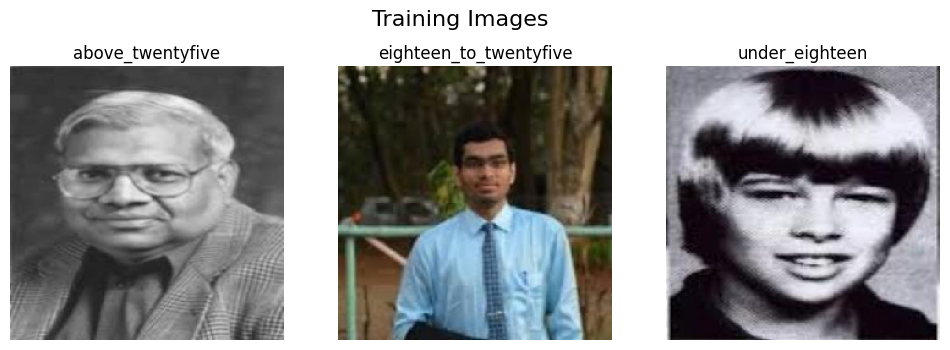

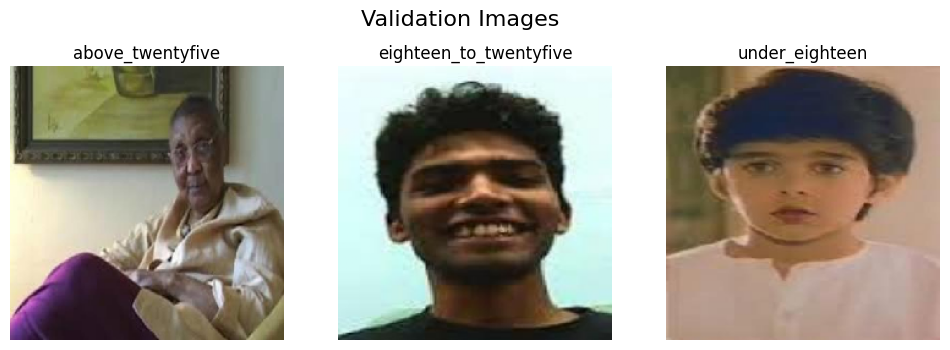

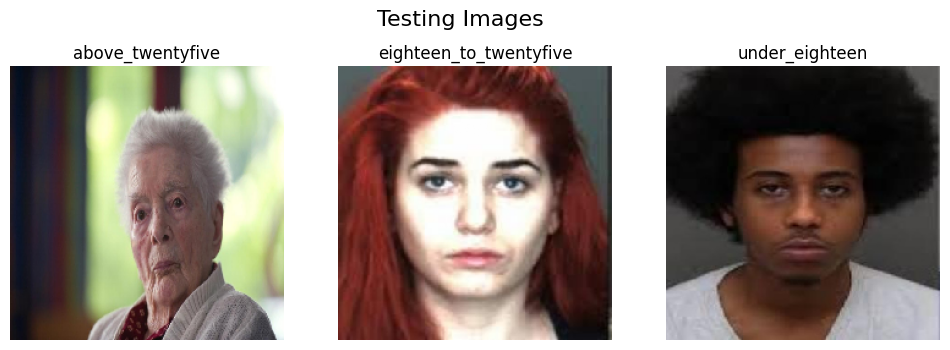

In [ ]:
# Assume X_train, y_train, class_names are defined
plot_images(X_train, y_train, class_names, title="Training Images")
plot_images(X_valid, y_valid, class_names, title="Validation Images")
plot_images(X_test, y_test, class_names, title="Testing Images")

### **Predefined functions**

The predefined functions below are property of Joaquin Vanschoren, given in an assignment from 2022 for the course Data Mining at JADS. These functions were used, because they allow us to load the models from the files directly, save the models into a directory, but most importantly, give a plot with information on the validation loss etc. while training a CNN.

In [ ]:
page.page = print

# Helper function for user feedback
def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# Helper function to format answers
def print_answer(ans):
    output = ""
    for line in ans.splitlines()[0:]:
        output += line.strip() + " "
    output += "(length: "+str(len(output))+")\n"
    print(output)


def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed.
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        # if a json description is available, load config and then weights
        if os.path.isfile(os.path.join(base_dir, name+'.json')):
            json_file = open(os.path.join(base_dir, name+'.json'), 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(os.path.join(base_dir, name+extension))
        # else just load the entire model from hdf5 file
        else:
            model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed.
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    path = os.path.join(base_dir, name+extension)
    model.save(path)
    size = os.path.getsize(path)
    # If model > 100MB, store the weights and architecture only.
    if size > 100*1024*1024:
        print("Model larger than 100MB, storing weights only.")
        model.save_weights(path)
        model_json = model.to_json()
        with open(os.path.join(base_dir, name+".json"), "w") as json_file:
            json_file.write(model_json)

# Evaluation harness
def run_evaluation(name, model_builder, data, base_dir, train=True,
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60,
                   verbose=1, print_model=True, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a
                     model summary, and a 'save' function that saves the model
                     to disk.
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data is given as a generator or not. Set batch size to None when using a generator.
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with. Set batch size to None when using a generator.
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    print_model -- whether or not to print the model
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}

    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1,
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
    # Report
    lc = pd.DataFrame(learning_curves)
    print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    plt.show()

    if print_model:
        print(model.summary())
    plot_model(model, to_file=os.path.join(base_dir,name+'.png'))

### **Model Training**

In [ ]:
# Set this to True to render and verify this notebook without retraining all the deep learning models.
# All models will be loaded from file instead.
stop_training = False

In [ ]:
y_train_encoded = to_categorical(y_train, num_classes=3)
y_valid_encoded = to_categorical(y_valid, num_classes=3)

eval_split = X_train, X_valid, y_train_encoded, y_valid_encoded

**Simple baseline model** \\
First, a simple baseline model is made to also be able to see how changes will improve an advanced model. For this, only Conv2D layers and MaxPooling layers are used.

In [ ]:
def create_image_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')  # Output layer for three classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Max val score: 83.40%


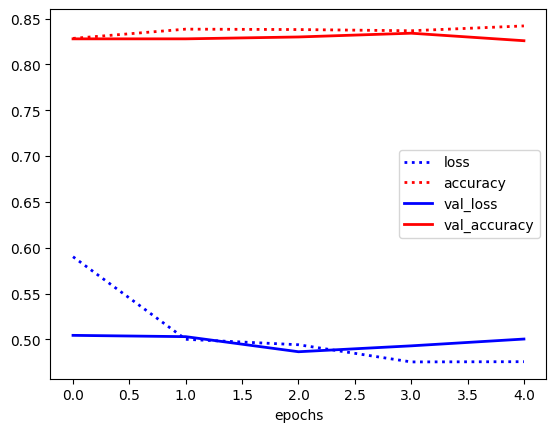

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [ ]:
run_evaluation("Simple face age classification model", create_image_model, eval_split, base_dir,
               train=True, epochs=5, batch_size=32)

**Advanced model** \\
An improvement of the simple model is made. This is done by trying to add different components, such as extra layers, Dropout layers and a regularizer. The Advanced  model below is the final model after several tried attempts.

Training the model
Epoch 1/10
72/72 [==============================] - 20s 147ms/step - loss: 0.8170 - accuracy: 0.8288 - val_loss: 0.8183 - val_accuracy: 0.8279
Epoch 2/10
72/72 [==============================] - 7s 96ms/step - loss: 0.6706 - accuracy: 0.8385 - val_loss: 0.7089 - val_accuracy: 0.8279
Epoch 3/10
72/72 [==============================] - 7s 96ms/step - loss: 0.6001 - accuracy: 0.8385 - val_loss: 0.5856 - val_accuracy: 0.8279
Epoch 4/10
72/72 [==============================] - 7s 93ms/step - loss: 0.5652 - accuracy: 0.8385 - val_loss: 0.6044 - val_accuracy: 0.8279
Epoch 5/10
72/72 [==============================] - 7s 95ms/step - loss: 0.5440 - accuracy: 0.8385 - val_loss: 0.5512 - val_accuracy: 0.8279
Epoch 6/10
72/72 [==============================] - 7s 93ms/step - loss: 0.5330 - accuracy: 0.8385 - val_loss: 0.5729 - val_accuracy: 0.8279
Epoch 7/10
72/72 [==============================] - 6s 90ms/step - loss: 0.5115 - accuracy: 0.8385 - val_loss: 0.5516 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/regularizers.py:426: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'tensorflow.python.keras.regularizers.L2'>, which may lead to improper serialization.
  warnings.warn(


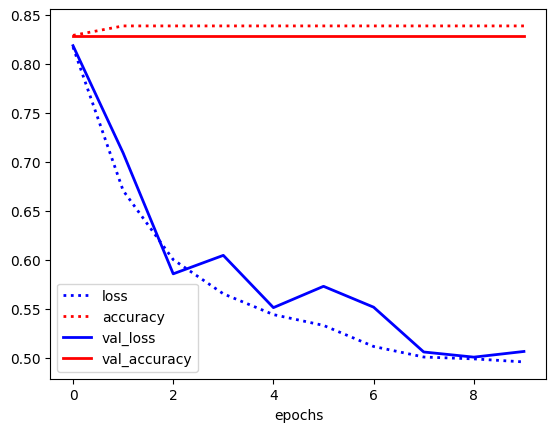

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 54, 54, 64)       

In [ ]:
stop_training = False
def create_image_model_advanced():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')  # Output layer for three classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

run_evaluation("Advanced face age classification model", create_image_model_advanced, eval_split, base_dir,
               train=True, epochs=10, batch_size=32)

### **Evaluation Metrics**
The models are evaluated using the accuracy score on the test test and making a confusion matrix.

In [ ]:
# This function performs a prediction on the test set and evaluates returns the accuracy score
def accuracy(model, X_test, y_test):
  model = load_model_from_file(base_dir, model)
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis = 1)
  return accuracy_score(y_test, y_pred)

In [ ]:
# The confusion matrix is made to see how the predictions behave. As can be seen in the report, having False Positives (predicted under 18) is better than having false negatives (people of under 18 predicted as older)
def confusion_matrix_plot(model, X_test, y_test, no_classes, class_names):
  model = load_model_from_file(base_dir, model)
  y_pred = model.predict(X_test)

  cm = confusion_matrix(y_test,np.argmax(y_pred, axis=1))
  fig, ax = plt.subplots()
  im = ax.imshow(cm)
  ax.set_xticks(np.arange(no_classes)), ax.set_yticks(np.arange(no_classes))
  ax.set_xticklabels(class_names, rotation=45, ha="right")
  ax.set_yticklabels(class_names)
  ax.set_ylabel('True')
  ax.set_xlabel('Predicted')
  for i in range(no_classes**2):
    ax.text(int(i/no_classes),i%no_classes,cm[i%no_classes,int(i/no_classes)], ha="center", va="center", color="w")

# A sample of the misclassifications is shows. This is done by showing the image, the actual category and the predicted category
def plot_misclassifications(model, X_test, y_test, class_names):
  model = load_model_from_file(base_dir, model)
  y_pred = model.predict(X_test)

  misclassified_samples = np.nonzero(y_test != np.argmax(y_pred, axis=1))[0]

  fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
  for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_test[i])
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (class_names[np.argmax(y_pred[i])], class_names[np.argmax(y_test[i])]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())


**Evaluation Simple model**

In [ ]:
test_accuracy_simple = accuracy("Simple face age classification model", X_test, y_test)
print("Test accuracy simple model:", test_accuracy_simple)

16/16 [==============================] - 1s 25ms/step
Test accuracy simple model: 0.8507157464212679


16/16 [==============================] - 0s 11ms/step


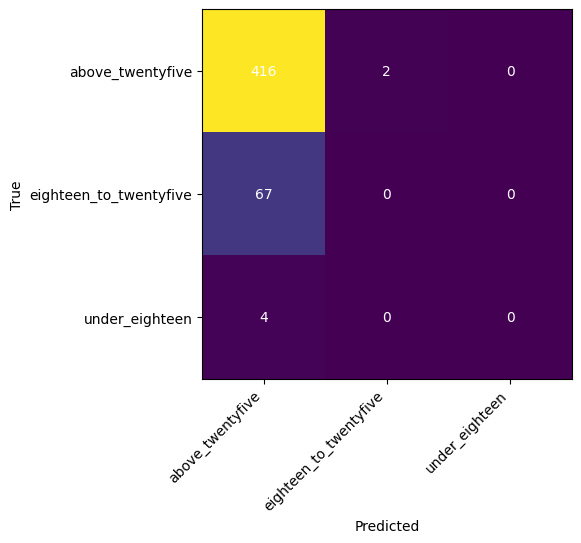

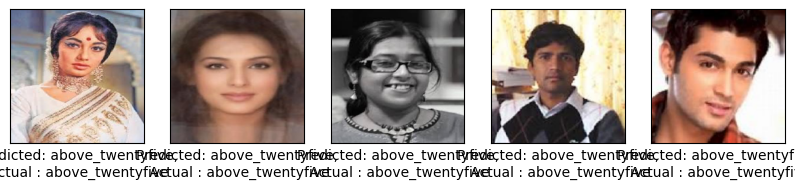

In [ ]:
confusion_matrix_plot("Simple face age classification model", X_test, y_test, 3, class_names)
plot_misclassifications("Simple face age classification model", X_test, y_test, class_names)

**Evaluation Advanced model**

In [ ]:
test_accuracy_advanced = accuracy("Advanced face age classification model", X_test, y_test)
print("Test accuracy advanced model:", test_accuracy_advanced)

16/16 [==============================] - 1s 55ms/step
Test accuracy advanced model: 0.8548057259713702


16/16 [==============================] - 0s 20ms/step


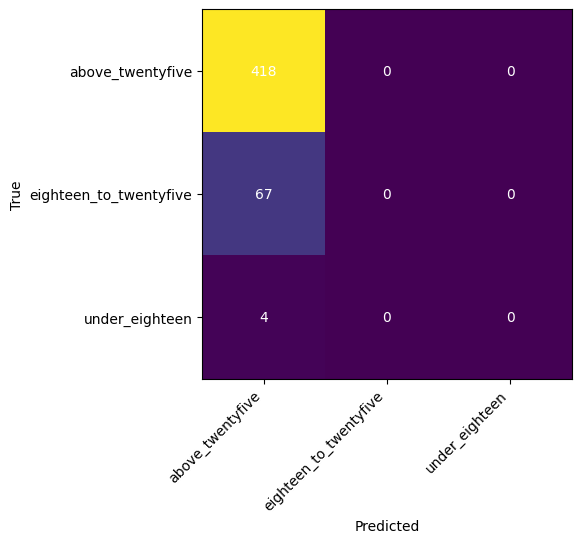

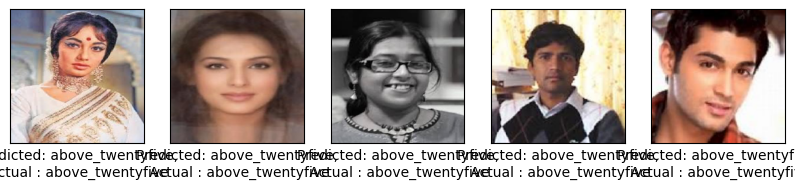

In [ ]:
confusion_matrix_plot("Advanced face age classification model", X_test, y_test, 3, class_names)
plot_misclassifications("Advanced face age classification model", X_test, y_test, class_names)

# **Data Augmentation**

The data is not equally divided between the three different categories. To create more images in the first two categories data augmentation is used. First the amount of images in each category gets determined.

In [ ]:
def amount_of_images(path):
  """
  Determine how many images there are in a folder
  """
  count = 0
  for filename in os.listdir(path):
    count += 1


  return count


In [ ]:
# Get the path for the below 18 category
add_path = "Data/Classes/under_eighteen"
path = (os.path.join(base_dir, add_path))

# Calculate the amount of images for the under 18 category
n_under_eighteen = amount_of_images(path)
print('Number of images in category under 18:', amount_of_images(path))

# Get the path for the between 18 & 25 category
add_path = "Data/Classes/eighteen_to_twentyfive"
path = (os.path.join(base_dir, add_path))

# Calculate the amount of images for the between 18 & 25 category
n_eighteen_to_twentyfive = amount_of_images(path)
print('Number of images in category between 18 and 25:', amount_of_images(path))

# Get the path for the above 25 category
add_path = "Data/Classes/above_twentyfive"
path = (os.path.join(base_dir, add_path))

# Calculate the amount of images for the above 25 category
n_above_twentyfive = amount_of_images(path)
print('Number of images in category above 25:', amount_of_images(path))

print('How many times category above 25 is bigger then the category under 18:', n_above_twentyfive / n_under_eighteen)

print('How many times category above 25 is bigger then the category between 18 and 25:', n_above_twentyfive / n_eighteen_to_twentyfive)

Number of images in category under 18: 57
Number of images in category between 18 and 25: 466
Number of images in category above 25: 2732
How many times category above 25 is bigger then the category under 18: 47.92982456140351
How many times category above 25 is bigger then the category between 18 and 25: 5.8626609442060085


The cell below only needs to be run once, to create a copy of the data used above

In [ ]:
# Copy the images to the augemented folder

# Copy the under 18 category
add_path = "Data/Classes/under_eighteen"
path = (os.path.join(base_dir, add_path))

add_path = "Data/Classes_augmented2/under_eighteen_aug"
destination_path = (os.path.join(base_dir, add_path))
for filename in os.listdir(path):
  shutil.copy(os.path.join(path, filename), os.path.join(destination_path, filename))


# Copy the between 18 & 25 category
add_path = "Data/Classes/eighteen_to_twentyfive"
path = (os.path.join(base_dir, add_path))

add_path = "Data/Classes_augmented2/eighteen_to_twentyfive_aug"
destination_path = (os.path.join(base_dir, add_path))
for filename in os.listdir(path):
  shutil.copy(os.path.join(path, filename), os.path.join(destination_path, filename))

# Copy the above 25 category
add_path = "Data/Classes/above_twentyfive"
path = (os.path.join(base_dir, add_path))

add_path = "Data/Classes_augmented2/above_twentyfive_aug"
destination_path = (os.path.join(base_dir, add_path))

for filename in os.listdir(path):
  shutil.copy(os.path.join(path, filename), os.path.join(destination_path, filename))


The cells below only need to run once!
They will created augmented images for the category under 18 and the category between 18 & 25

In [ ]:
# This will create 10 augemented images for each image in the under eighteen category

add_path = "Data/Classes_augmented2/under_eighteen_aug"
path = (os.path.join(base_dir, add_path))
augment_images(path, 10)

In [ ]:
# This will create 2 augemented images for each image in the between 18 and 25 category

add_path = "Data/Classes_augmented2/eighteen_to_twentyfive_aug"
path = (os.path.join(base_dir, add_path))
augment_images(path, 2)

Below the new amount of images in each category gets determined.

In [ ]:
# Get the path for the below 18 category
add_path = "Data/Classes_augmented2/under_eighteen_aug"
path = (os.path.join(base_dir, add_path))

# Calculate the amount of images for the under 18 category
n_under_eighteen = amount_of_images(path)
print('New number of images in category under 18:', amount_of_images(path))

# Get the path for the between 18 & 25 category
add_path = "Data/Classes_augmented2/eighteen_to_twentyfive_aug"
path = (os.path.join(base_dir, add_path))

# Calculate the amount of images for the between 18 & 25 category
n_eighteen_to_twentyfive = amount_of_images(path)
print('New number of images in category between 18 and 25:', amount_of_images(path))

# Get the path for the above 25 category
add_path = "Data/Classes_augmented2/above_twentyfive_aug"
path = (os.path.join(base_dir, add_path))

# Calculate the amount of images for the above 25 category
n_above_twentyfive = amount_of_images(path)
print('New number of images in category above 25:', amount_of_images(path))

print('How many times category above 25 is bigger then the category under 18:', n_above_twentyfive / n_under_eighteen)

print('How many times category above 25 is bigger then the category between 18 and 25:', n_above_twentyfive / n_eighteen_to_twentyfive)

New number of images in category under 18: 627
New number of images in category between 18 and 25: 1398
New number of images in category above 25: 2732
How many times category above 25 is bigger then the category under 18: 4.35725677830941
How many times category above 25 is bigger then the category between 18 and 25: 1.954220314735336


# **Models on augmented data**


In [ ]:
# Base directory where the folders are stored
add_path = "Data/Classes_augmented2" # Path to augmented data, change accordingly
path_aug = (os.path.join(base_dir, add_path))
class_names_aug = ['above_twentyfive_aug', 'eighteen_to_twentyfive_aug', 'under_eighteen_aug']

# Desired size for all images
img_height, img_width = 224, 224 # Example size, adjust as needed


In [ ]:
# Load images and labels into numpy arrays
images, labels = load_images_and_labels(path_aug, class_names_aug, img_height, img_width)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'Train set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_valid.shape}, {y_valid.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Train set: (3329, 224, 224, 3), (3329,)


In the cell below the arrays where we train the model on a are saved. This is done to save RAM use when traning the models

In [ ]:
np.save('X_train.npy', X_train)

np.save('y_train.npy', y_train)

np.save('X_valid.npy', X_valid)

np.save('X_test.npy', X_test)

np.save('y_valid.npy', y_valid)

np.save('y_test.npy', y_test)

Here the arrays that were previously saved we will loaded in to the train the model

In [ ]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')


X_valid = np.load('X_valid.npy')
X_test = np.load('X_test.npy')


y_valid = np.load('y_valid.npy')
y_test = np.load('y_test.npy')


array([0, 0, 1, ..., 1, 1, 0])

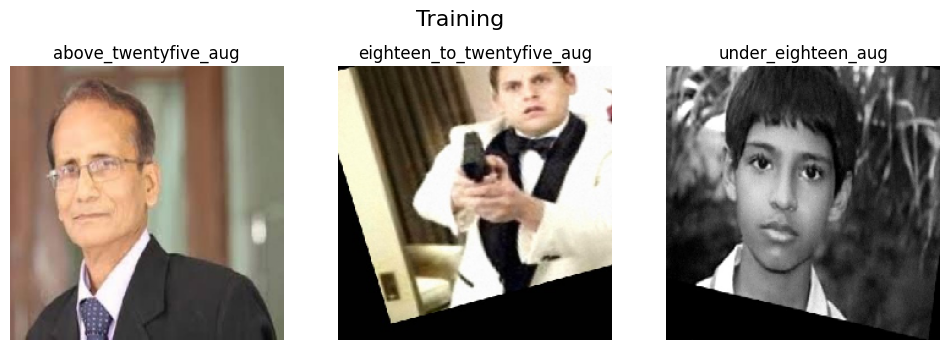

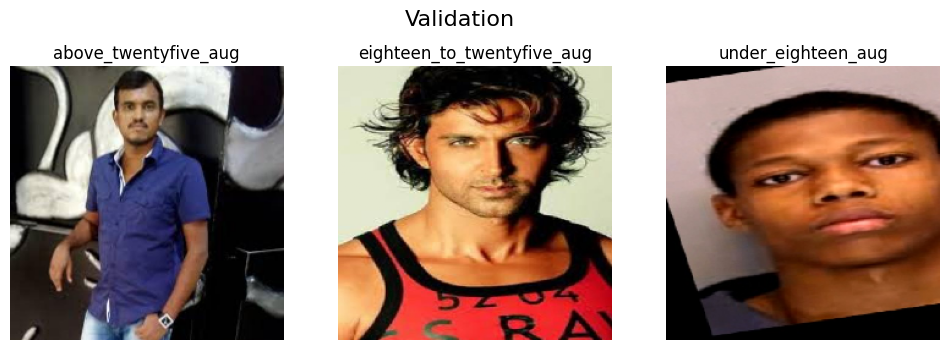

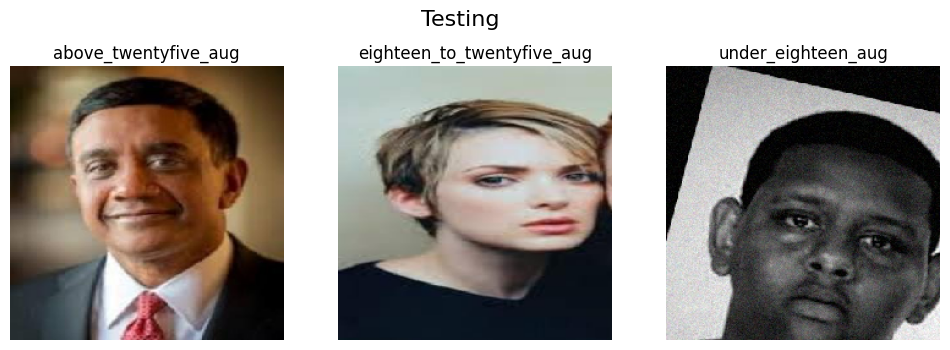

In [ ]:
# Plot augmented images
plot_images(X_train, y_train, class_names_aug, title = "Training")
plot_images(X_valid, y_valid, class_names_aug, title = "Validation")
plot_images(X_test, y_test, class_names_aug, title = "Testing")

Model Training on Augemented Data

In [ ]:
def augment_images(directory, amount):
  """
  This function augments the images in the given dicrectory and will also add the augemented images to the same directory.
  It performs random augmentation on each image in the given folder.
  """
  # Iterate over all files in the directory
  for filename in os.listdir(directory):
      if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust extensions as needed
          # Construct the full path to the image
          filepath = os.path.join(directory, filename)

          # Load the image
          image = cv2.imread(filepath)

          # Define your augmentation sequence
          seq = iaa.Sequential([
              iaa.Fliplr(0.5),  # Horizontal flips
              iaa.Crop(percent=(0, 0.1)),  # Random crops
              iaa.Sometimes(0.5,
                  iaa.GaussianBlur(sigma=(0, 0.5)) #Add some Guassian Blur
              ),
              iaa.ContrastNormalization((0.75, 1.5)),  # Strengthen or weaken the contrast
              iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),  # Add gaussian noise
              iaa.Multiply((0.8, 1.2), per_channel=0.2),  # Multiply some images channels
              iaa.Sometimes(0.5,
                            iaa.Grayscale(alpha=1.0)), # Convert the image to grayscale
              iaa.Affine(
                  scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                  translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                  rotate=(-25, 25),
                  shear=(-8, 8)
              )
          ], random_order=True)  # apply augmenters in random order

          # Convert the image from BGR to RGB
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

          # Apply augmentation
          augmented_images = [seq.augment_image(image) for _ in range(amount)]  # amount is the number of augmented images per original image

          for i, augmented_image in enumerate(augmented_images):
              # Define new filename based on the original filename
              new_filename = f"{os.path.splitext(filename)[0]}_augmented_{i}.jpg"
              new_filepath = os.path.join(directory, new_filename)

              # Convert image back to BGR for saving
              augmented_image_bgr = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

              # Save the augmented image
              cv2.imwrite(new_filepath, augmented_image_bgr)


In [ ]:
# Set this to True to render and verify this notebook without retraining all the deep learning models.
# All models will be loaded from file instead.
stop_training = False

**Simple model on augmented data**


In [ ]:
y_train_encoded = to_categorical(y_train, num_classes=3)
y_valid_encoded = to_categorical(y_valid, num_classes=3)

eval_split = X_train, X_valid, y_train_encoded, y_valid_encoded

In [ ]:
def create_image_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')  # Output layer for three classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Training the model
Epoch 1/5
105/105 [==============================] - 14s 66ms/step - loss: 0.9593 - accuracy: 0.6663 - val_loss: 0.6706 - val_accuracy: 0.7115
Epoch 2/5
105/105 [==============================] - 5s 52ms/step - loss: 0.6146 - accuracy: 0.7459 - val_loss: 0.7280 - val_accuracy: 0.6555
Epoch 3/5
105/105 [==============================] - 5s 49ms/step - loss: 0.5498 - accuracy: 0.7666 - val_loss: 0.6266 - val_accuracy: 0.7227
Epoch 4/5
105/105 [==============================] - 6s 53ms/step - loss: 0.4305 - accuracy: 0.8297 - val_loss: 0.7253 - val_accuracy: 0.7003
Epoch 5/5
105/105 [==============================] - 5s 49ms/step - loss: 0.3084 - accuracy: 0.8756 - val_loss: 0.8330 - val_accuracy: 0.7171
Saving to file


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model larger than 100MB, storing weights only.
Model stored in /content/drive/My Drive/JADS/Deep_learning/
Max val score: 72.27%


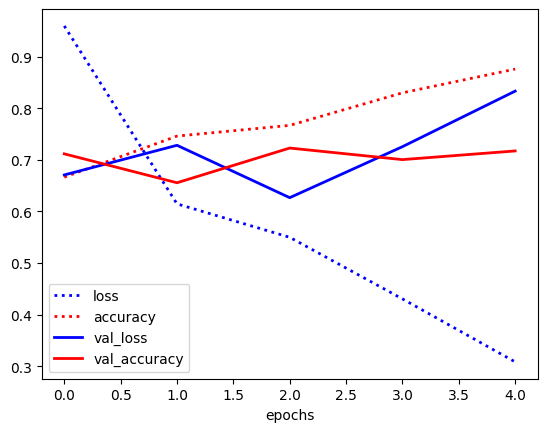

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

In [ ]:
run_evaluation("Augmented Simple face age classification model", create_image_model, eval_split, base_dir,
               train=True, epochs=5, batch_size=32)

**Advanced model on augmented data**

In [ ]:
y_train_encoded = to_categorical(y_train, num_classes=3)
y_valid_encoded = to_categorical(y_valid, num_classes=3)

eval_split = X_train, X_valid, y_train_encoded, y_valid_encoded

Training the model
Epoch 1/10
105/105 [==============================] - 23s 120ms/step - loss: 1.1866 - accuracy: 0.5599 - val_loss: 1.0586 - val_accuracy: 0.5840
Epoch 2/10
105/105 [==============================] - 10s 94ms/step - loss: 0.9718 - accuracy: 0.6371 - val_loss: 1.0254 - val_accuracy: 0.6204
Epoch 3/10
105/105 [==============================] - 10s 93ms/step - loss: 0.8432 - accuracy: 0.6750 - val_loss: 0.9729 - val_accuracy: 0.6639
Epoch 4/10
105/105 [==============================] - 10s 94ms/step - loss: 0.7598 - accuracy: 0.7035 - val_loss: 0.8160 - val_accuracy: 0.6513
Epoch 5/10
105/105 [==============================] - 10s 96ms/step - loss: 0.7263 - accuracy: 0.7077 - val_loss: 0.7655 - val_accuracy: 0.7129
Epoch 6/10
105/105 [==============================] - 10s 94ms/step - loss: 0.7128 - accuracy: 0.7179 - val_loss: 0.6867 - val_accuracy: 0.7171
Epoch 7/10
105/105 [==============================] - 10s 92ms/step - loss: 0.6856 - accuracy: 0.7230 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/regularizers.py:426: UserWarning: The `keras.regularizers.serialize()` API should only be used for objects of type `keras.regularizers.Regularizer`. Found an instance of type <class 'tensorflow.python.keras.regularizers.L2'>, which may lead to improper serialization.
  warnings.warn(


Model stored in /content/drive/My Drive/JADS/Deep_learning/
Max val score: 71.71%


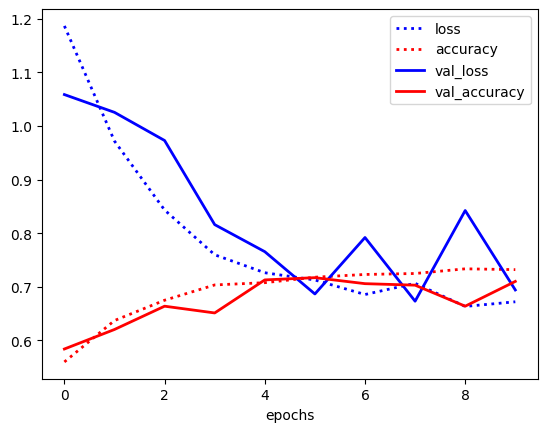

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 64)        0

In [ ]:
stop_training = False

def create_image_model_advanced():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')  # Output layer for three classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

run_evaluation("Augmented Advanced face age classification model", create_image_model_advanced, eval_split, base_dir,
               train=True, epochs=10, batch_size=32)

Evaluation Simple Model Augmented

In [ ]:
test_accuracy_simple_aug = accuracy("Augmented Simple face age classification model", X_test, y_test)
print("Test accuracy simple model augmented:", test_accuracy_simple_aug)

23/23 [==============================] - 7s 35ms/step
Test accuracy simple model augmented: 0.7058823529411765


23/23 [==============================] - 1s 14ms/step


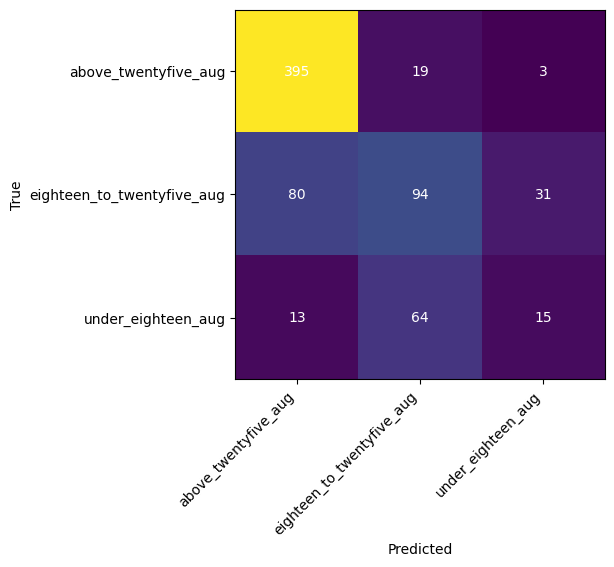

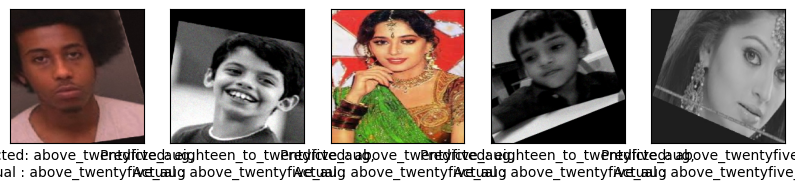

In [ ]:
confusion_matrix_plot("Augmented Simple face age classification model", X_test, y_test, 3, class_names_aug)
plot_misclassifications("Augmented Simple face age classification model", X_test, y_test, class_names_aug)

Evaluation Advanced model augmented

In [ ]:
test_accuracy_advanced_aug = accuracy("Augmented Advanced face age classification model", X_test, y_test)
print("Test accuracy advanced model augmented:", test_accuracy_advanced_aug)

23/23 [==============================] - 1s 30ms/step
Test accuracy advanced model augmented: 0.7128851540616247


23/23 [==============================] - 1s 18ms/step


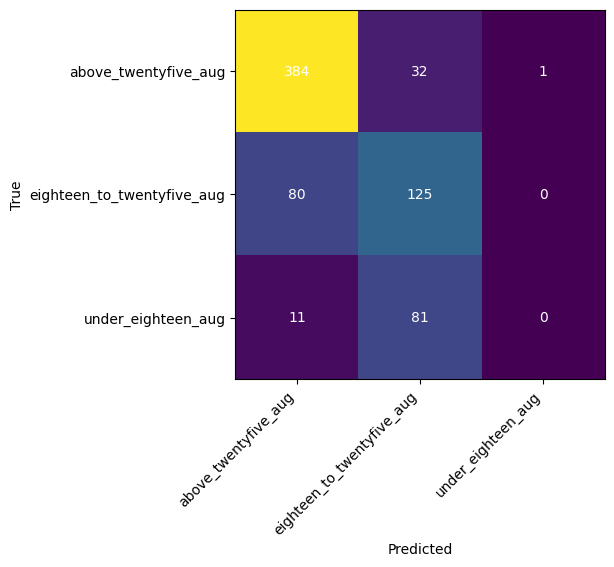

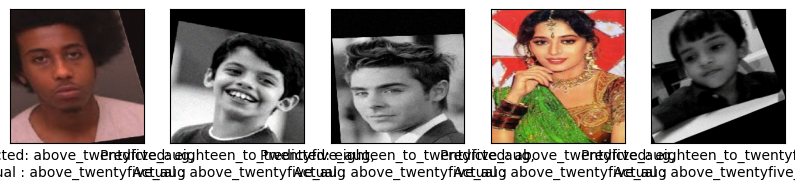

In [ ]:
confusion_matrix_plot("Augmented Advanced face age classification model", X_test, y_test, 3, class_names_aug)
plot_misclassifications("Augmented Advanced face age classification model", X_test, y_test, class_names_aug)